# I. Preparation

## Install & Import packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
import datetime
from datetime import datetime as dt
from datetime import timezone

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/demographic.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.head()

,index,flag_bad,de_age,de_gender,de_date_joined,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_accomodation_type,...,de_children,ph_total_contacts,ph_other_device_info,ph_call_log_stats,ph_country_code,ph_app_list,fb_gender,fb_dob,fb_last_updated_date,fb_relation
0,0,0,26,1,08/04/2018 14:50,2535,3000000,1,51,4,...,0,66,"{""device_codename"": ""HM2014817"", ""brand"": ""Xia...","{""percent_incoming_nighttime"": 1.83, ""percent_...",id,"['com.google.android.music', 'com.facebook.orc...",male,11/23/1991,2017-12-21T04:38:00+0000,Married
1,1,0,22,1,02/01/2018 17:17,685,4000000,1,28,4,...,0,69,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.google.android.instantapps.supervisor', ...",male,01/20/1995,2017-11-25T17:23:09+0000,NaN
2,2,1,32,1,01/01/2018 16:39,1765,7000000,1,35,4,...,2,315,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 6.65, ""percent_...",id,"['com.tencent.ibg.joox', 'com.mrgames.larvaact...",male,10/13/1985,2017-12-23T18:05:57+0000,Married
3,3,0,31,2,04/01/2018 22:36,407,20000000,3,37,4,...,2,84,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...",female,07/27/1986,2017-12-05T09:37:19+0000,Married
4,4,0,27,1,02/01/2018 18:12,3064,3000000,1,36,4,...,0,0,"{""device_codename"": ""1609"", ""brand"": ""vivo""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl...",male,07/05/1990,2017-12-03T09:09:48+0000,In a relationship


In [ ]:
df.columns

Index(['index', 'flag_bad', 'de_age', 'de_gender', 'de_date_joined',
       'de_num_friends', 'de_monthly_salary', 'de_employment_type',
       'de_employment_duration', 'de_accomodation_type', 'de_education',
       'de_marital_status', 'de_children', 'ph_total_contacts',
       'ph_other_device_info', 'ph_call_log_stats', 'ph_country_code',
       'ph_app_list', 'fb_gender', 'fb_dob', 'fb_last_updated_date',
       'fb_relation'],
      dtype='object')

## Define functions

### Outlier view

In [ ]:
def outlier_view(df, threshold = 3):
  """
    Take dataframe with continous data type only. Return dataframe with column name, 
    nb of outliers and percentage with threshold defined (default = 3)
  """
  result = []

  for col in df.columns:

    std = df[col].std()
    mean = df[col].mean()
    # df_tmp = df.loc[df[col]].notna() #threshold*std + mean
    total = df.loc[(df[col] > (threshold * std + mean)) & (df[col].notna()), col].count()

    percent = round(total / len(df), 2)
    tmp = [col, total, percent]
    result.append(tmp)
  df = pd.DataFrame(result, columns=['column', 'total_outliers', 'percent'])
  return df

### Remove outliers

In [ ]:
def outlier_remove(df, columns, threshold = 3):
  """
    Input: dataframe, columns with continous values only
    Output: dataframe with outliers removed (threshold = 3 optional), missing rows are kept
  """
  for col in num_cols:
    type_ = str(df[col].dtype)
    if type in ['object', 'category']:
      print(f'Columns {col} contains categorical values')
      break
    else:
      std = df[col].std()
      mean = df[col].mean()
      df = df.loc[(df[col] <= (threshold * std + mean)) | (df[col].isnull()), :]
  return df

### Parse json data

In [ ]:
def parse_json_columns(df, cols):
  """
    Function will parse data in json from columns and concat to input dataframe

    df: dataframe input (contains the columns)
    columns: array of columns containing data in json
    output: df after concaternation
  """
  
  for j_column in cols:

    # Get first non-empty row:
    not_null_row = df.loc[df[j_column].notnull(), j_column][0]

    # Get keys
    new_cols = json.loads(not_null_row).keys()

    # Create new json object for null values replacement
    value_replace = {} #dict

    for col in new_cols:
      data = None
      value_replace[col] = data

    value_replace = json.dumps(value_replace) #json

    # Replace null values in j_column
    df.loc[df[j_column].isnull(), j_column] = value_replace

    # # Create new dictionary stores all values in this columns
    # new_cols_dict_ = {}
    # for col in new_cols:
    #   data = []
    #   new_cols_dict_[col] = data

    # for row_ in df[j_column]:
    #   # print(row_)
    #   row_ = json.loads(row_) # type dict

    #   for item in row_.keys():
    #     new_cols_dict_[item].append(row_[item])
    
    # Create new dataframe from json
    df_unfolded = pd.json_normalize(df[j_column].apply(json.loads))

    # Drop column `ph_call_log_stats`
    df.drop(j_column, axis=1, inplace=True)

    # # Concat 2 dataframes
    df = pd.concat([df, df_unfolded], axis = 1)
    
  return df


### Get number of continous and categorical features

In [ ]:
def group_columns_by_dtype(df):
  """
    Iterate through all columns from dataframe `df`, count the number of categorical columns and continuous columns
    df: dataframe
    output: tuple
  """
  # Get dictionary of columns and dtypes
  dict_ = df.dtypes.to_dict()
  result = {}
  categorical = []
  continous = []
  # Categorical features = object, category
  # Continous features = int, float
  for k, v in dict_.items():
    if str(v) in ['object', 'category']:
      categorical.append(k)
    else:
      continous.append(k)

  result['categorical'] = categorical
  result['continous'] = continous

  return result

### Convert timestamp to days

In [ ]:
def get_days(timestamp):
  day = timestamp.days
  return day

## Unfold json data columns

Unfold json data from `ph_call_log_stats`, `ph_other_device_info` columns


In [ ]:
# Columns with data in json
cols = ['ph_other_device_info', 'ph_call_log_stats']
# Unfold
df = parse_json_columns(df, cols)
print(f'Number of columns: {len(df.columns)}')

Number of columns: 32


# II. Exploratory Data Analysis

## Column data types

In [ ]:
# Number of columns in each dtype
df.dtypes.value_counts()

int64      13
float64    10
object      9
dtype: int64

In [ ]:
# Group columns by their dtype
tmp = group_columns_by_dtype(df)

cate_cols = tmp['categorical']
num_cols = tmp['continous']

print(f'{len(cate_cols)} categorical columns - {len(num_cols)} continous columns')

9 categorical columns - 23 continous columns


In [ ]:
# Number of unique class in each continous column
df[num_cols].apply(pd.Series.nunique, axis = 0)


index                          41022
flag_bad                           2
de_age                            50
de_gender                          2
de_num_friends                  4531
de_monthly_salary                 40
de_employment_type                 4
de_employment_duration            52
de_accomodation_type               1
de_education                       5
de_marital_status                  4
de_children                        5
ph_total_contacts               1588
percent_incoming_nighttime      1983
percent_outgoing_daytime        5927
duration_incoming_daytime       8087
duration_outgoing_daytime       8080
percent_incoming_daytime        4286
percent_other_calls             5186
duration_outgoing_nighttime     5288
percent_outgoing_nighttime      3754
total_calls                      826
duration_incoming_nighttime     4643
dtype: int64

In [ ]:
# Let's move columns with less than 10 unique classes to categorical group
dict_tmp = df[num_cols].apply(pd.Series.nunique, axis = 0).to_dict()
for k,v in dict_tmp.items():
  if v < 10:
    num_cols.remove(k)
    cate_cols.append(k)

## Categorical data

### Over view

In [ ]:
# Categorical columns
df[cate_cols].head()

,de_date_joined,ph_country_code,ph_app_list,fb_gender,fb_dob,fb_last_updated_date,fb_relation,device_codename,brand,flag_bad,de_gender,de_employment_type,de_accomodation_type,de_education,de_marital_status,de_children
0,08/04/2018 14:50,id,"['com.google.android.music', 'com.facebook.orc...",male,11/23/1991,2017-12-21T04:38:00+0000,Married,HM2014817,Xiaomi,0,1,1,4,2,2,0
1,02/01/2018 17:17,id,"['com.google.android.instantapps.supervisor', ...",male,01/20/1995,2017-11-25T17:23:09+0000,NaN,A1601,OPPO,0,1,1,4,4,1,0
2,01/01/2018 16:39,id,"['com.tencent.ibg.joox', 'com.mrgames.larvaact...",male,10/13/1985,2017-12-23T18:05:57+0000,Married,A1601,OPPO,1,1,1,4,4,2,2
3,04/01/2018 22:36,id,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...",female,07/27/1986,2017-12-05T09:37:19+0000,Married,A1601,OPPO,0,2,3,4,3,2,2
4,02/01/2018 18:12,id,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl...",male,07/05/1990,2017-12-03T09:09:48+0000,In a relationship,1609,vivo,0,1,1,4,3,1,0


As we can see, `de_date_joined`, `fb_dob` and `fb_last_updated_date` contains values in datetime. Let's move them to a list of datetime features.

In [ ]:
date_cols = ['de_date_joined', 'fb_dob', 'fb_last_updated_date']
cate_cols = [x for x in cate_cols if x not in date_cols]

In [ ]:
# Number of unique class in each columns
df[cate_cols].apply(pd.Series.nunique, axis = 0)

ph_country_code             8
ph_app_list             40097
fb_gender                   2
fb_relation                17
device_codename          1041
brand                     133
flag_bad                    2
de_gender                   2
de_employment_type          4
de_accomodation_type        1
de_education                5
de_marital_status           4
de_children                 5
dtype: int64

In [ ]:
# Number of missing values
df[cate_cols].isnull().sum()

ph_country_code            25
ph_app_list                 0
fb_gender                1513
fb_relation             26461
device_codename             0
brand                       0
flag_bad                    0
de_gender                   0
de_employment_type          0
de_accomodation_type        0
de_education                0
de_marital_status           0
de_children                 0
dtype: int64

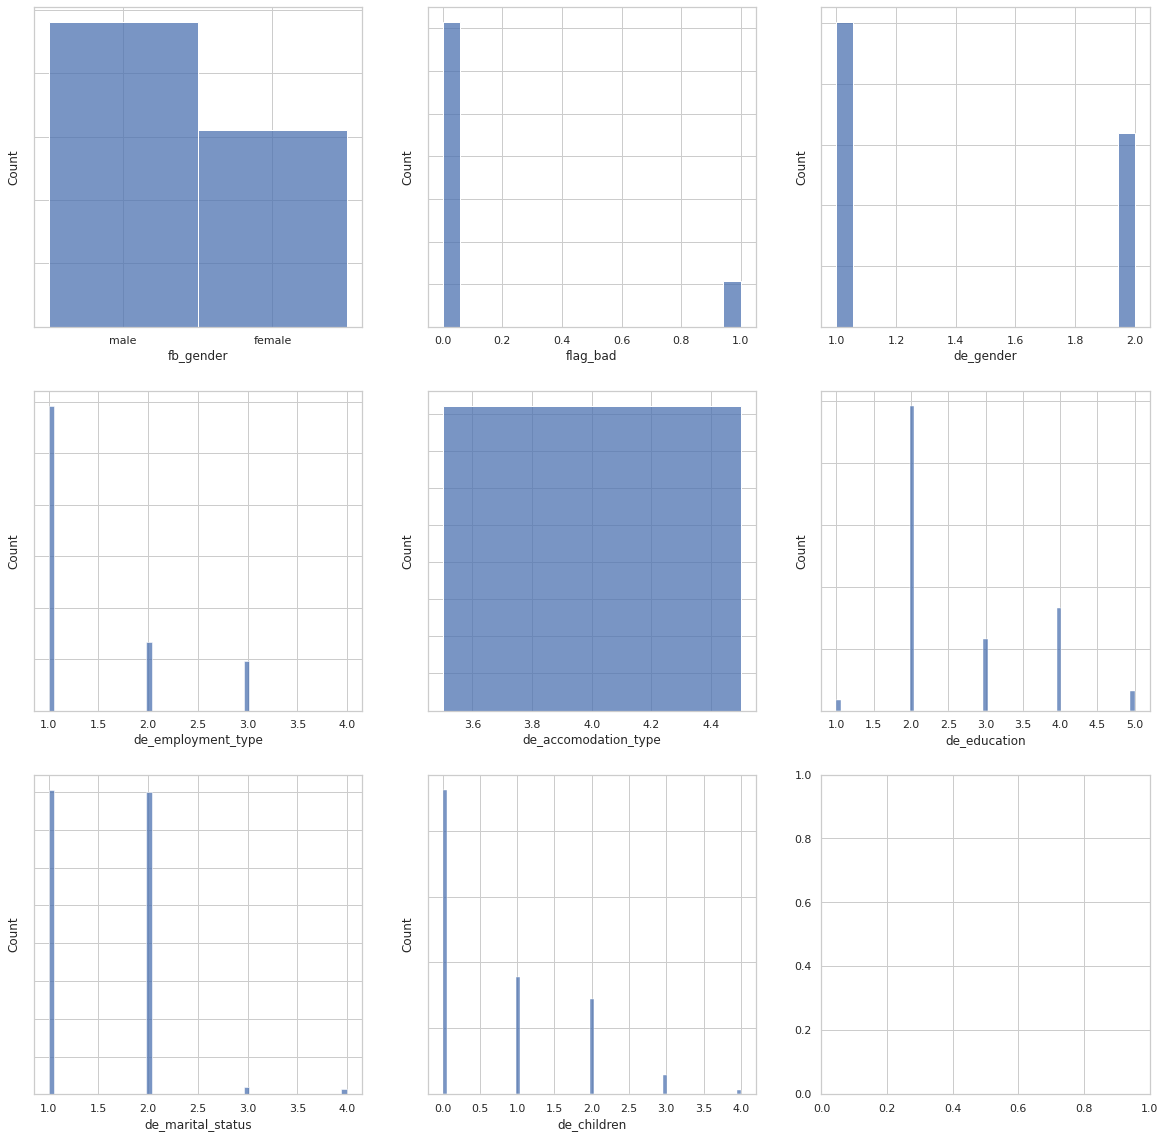

In [ ]:
# create a subplot of 3 x 3
tmp = [col for col in cate_cols if df[col].nunique() < 6]
sns.set_theme(style="whitegrid")
plt.subplots(3,3,figsize=(20,20))
i = 0
# Plot a density plot for each variable
for idx, col in enumerate(tmp):
    ax = plt.subplot(3,3,idx+1)
    ax.yaxis.set_ticklabels([])
    try:
      sns.histplot(x=df[col])
    except:
      pass
    # ax.set_title(col)

# # Hide the 24, 25th subplot (bottom right) since there are only 23 plots
# plt.subplot(5,5,24).set_visible(False)
# plt.subplot(5,5,25).set_visible(False)

plt.show()

### `ph_country_code`

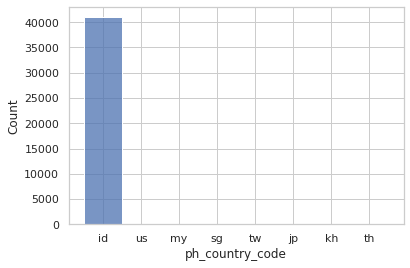

In [ ]:
# Plot a histogram
sns.histplot(x='ph_country_code', data=df[cate_cols])

In [ ]:
# Unique values occurence
df['ph_country_code'].value_counts()

id    40984
us        3
sg        3
my        2
jp        2
tw        1
kh        1
th        1
Name: ph_country_code, dtype: int64

Most of the values is id

### `ph_app_list`

In [ ]:
df['ph_app_list'].head(10)

0    ['com.google.android.music', 'com.facebook.orc...
1    ['com.google.android.instantapps.supervisor', ...
2    ['com.tencent.ibg.joox', 'com.mrgames.larvaact...
3    ['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...
4    ['com.lenovo.anyshare.gps', 'com.UCMobile.intl...
5    ['com.soundcloud.android', 'com.lenovo.anyshar...
6    ['com.rarlab.rar', 'com.kreditpintar', 'com.wh...
7    ['com.finaccel.android', 'com.whatsapp', 'com....
8    ['ovo.id', 'com.vuclip.viu', 'com.grabtaxi.pas...
9    ['mega.privacy.android.app', 'com.musixmatch.a...
Name: ph_app_list, dtype: object

Values are stored in a list. Basically, it reflects the type of app user are using

### `Brand`

Let's standardize columns `brand` values by uppercase all characters

In [ ]:
df['brand'] = df['brand'].str.upper()

In [ ]:
# Unique values occurence
df['brand'].value_counts()

XIAOMI      13764
SAMSUNG      8871
OPPO         7474
VIVO         2460
ASUS         2425
            ...  
KYOCERA         1
QCOM            1
VODAFONE        1
MAXTRON         1
O3              1
Name: brand, Length: 107, dtype: int64

In [ ]:
df_tmp = pd.DataFrame(df['brand'].value_counts().rename_axis('brand').reset_index(name='counts'))
df_tmp['percent'] = df_tmp['counts']/sum(df_tmp['counts'])
# Percentage of top 5 values
df_tmp.head(5)['percent'].sum()

0.8530544585831992

The first 5 groups take more than 85%.

## Continous data

### Over view

In [ ]:
# Categorical columns
df[num_cols].describe()

,index,de_age,de_num_friends,de_monthly_salary,de_employment_duration,ph_total_contacts,percent_incoming_nighttime,percent_outgoing_daytime,duration_incoming_daytime,duration_outgoing_daytime,percent_incoming_daytime,percent_other_calls,duration_outgoing_nighttime,percent_outgoing_nighttime,total_calls,duration_incoming_nighttime
count,41022.000000,41022.000000,41022.000000,4.102200e+04,41022.000000,41022.000000,38935.000000,38935.000000,38935.000000,3.893500e+04,38935.000000,38935.000000,38935.000000,38935.000000,38935.000000,3.893500e+04
mean,20510.500000,28.170908,1270.023987,5.182707e+06,33.437887,127.032568,5.147761,34.750085,2140.144651,2.276878e+03,18.952398,24.670238,1257.770720,13.120019,106.800796,8.943493e+02
std,11842.175708,6.537795,1188.849670,3.751306e+06,16.586586,319.078176,7.249589,21.989523,4863.969466,9.110616e+03,15.067259,20.148271,6457.274568,14.239384,131.901441,1.547035e+04
min,0.000000,18.000000,-1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-81677.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-2.860188e+06
25%,10255.250000,23.000000,437.000000,3.000000e+06,18.000000,0.000000,0.000000,18.520000,143.000000,3.700000e+01,8.330000,10.450000,0.000000,3.130000,25.000000,0.000000e+00
50%,20510.500000,27.000000,867.000000,4.000000e+06,36.000000,0.000000,3.230000,34.090000,725.000000,4.540000e+02,16.670000,20.000000,73.000000,9.570000,65.000000,9.800000e+01
75%,30765.750000,32.000000,1663.000000,5.000000e+06,51.000000,144.000000,7.140000,49.585000,2309.000000,1.939500e+03,26.670000,34.070000,541.000000,18.320000,138.000000,4.650000e+02
max,41021.000000,73.000000,5000.000000,4.100000e+07,51.000000,17315.000000,100.000000,100.000000,320131.000000,1.229976e+06,100.000000,100.000000,280726.000000,100.000000,3023.000000,4.495460e+05


In [ ]:
# Check missing values
df[num_cols].isnull().sum()

index                             0
de_age                            0
de_num_friends                    0
de_monthly_salary                 0
de_employment_duration            0
ph_total_contacts                 0
percent_incoming_nighttime     2087
percent_outgoing_daytime       2087
duration_incoming_daytime      2087
duration_outgoing_daytime      2087
percent_incoming_daytime       2087
percent_other_calls            2087
duration_outgoing_nighttime    2087
percent_outgoing_nighttime     2087
total_calls                    2087
duration_incoming_nighttime    2087
dtype: int64

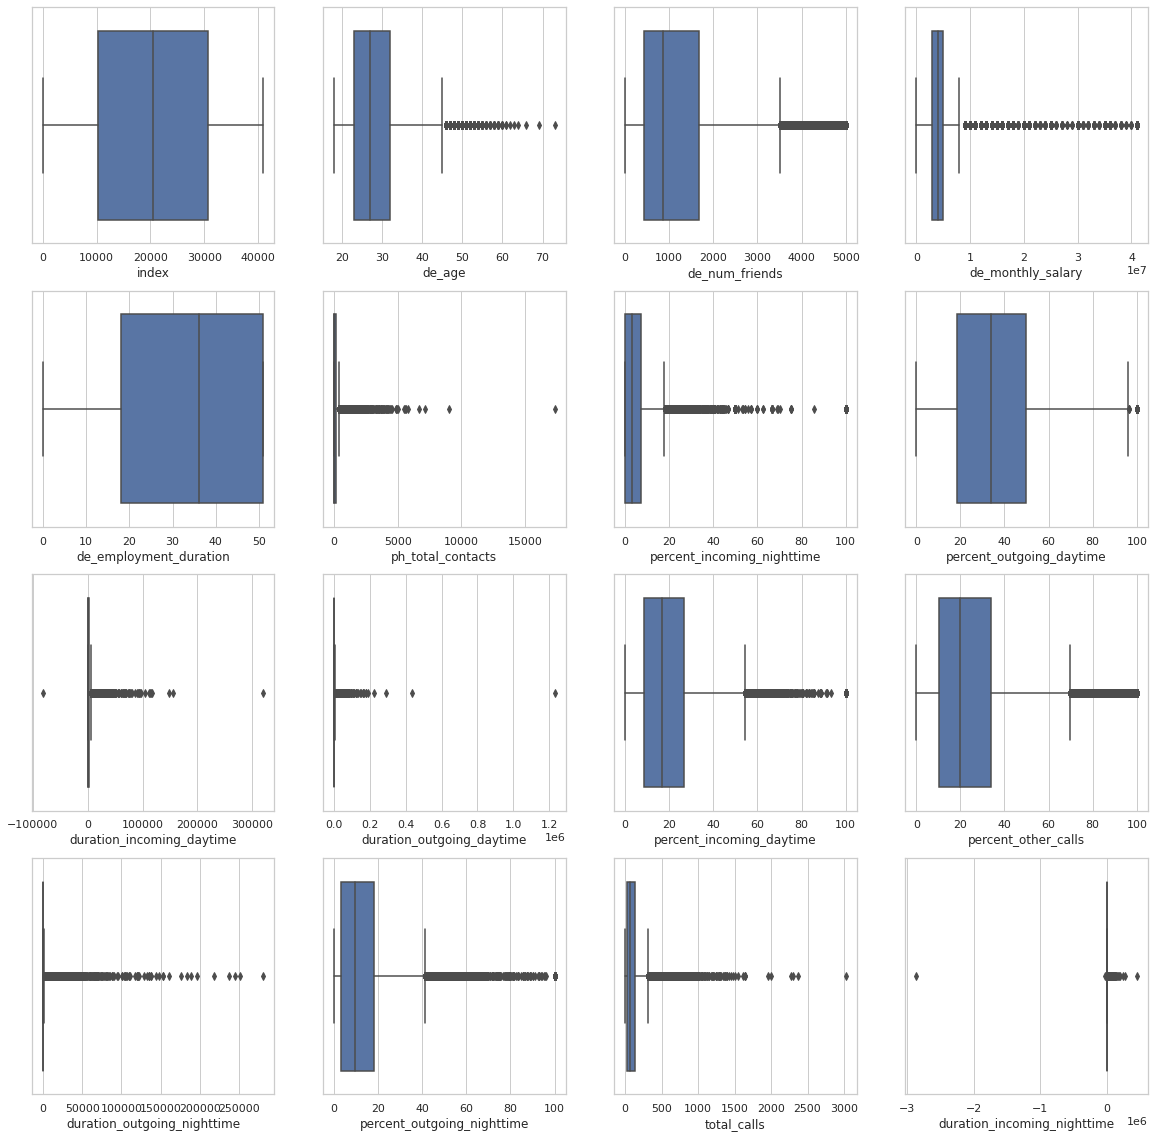

In [ ]:
# create a subplot of 3 x 3
sns.set_theme(style="whitegrid")
plt.subplots(4,4,figsize=(20,20))
i = 0
# Plot a density plot for each variable
for idx, col in enumerate(num_cols):

    ax = plt.subplot(4,4,idx+1)
    ax.yaxis.set_ticklabels([])
    try:
      sns.boxplot(x=df[col])
    except:
      pass
    # ax.set_title(col)

# # Hide the 24, 25th subplot (bottom right) since there are only 23 plots
# plt.subplot(5,5,24).set_visible(False)
# plt.subplot(5,5,25).set_visible(False)

plt.show()

Most of the data skews to the right

# III. Data Preprocessing

## Data cleansing

### Categorical features

In [ ]:
df[cate_cols].apply(pd.Series.nunique)

ph_country_code             8
ph_app_list             40097
fb_gender                   2
fb_relation                17
device_codename          1041
brand                     107
flag_bad                    2
de_gender                   2
de_employment_type          4
de_accomodation_type        1
de_education                5
de_marital_status           4
de_children                 5
dtype: int64

#### `ph_country_code`

In [ ]:
# Number of missing values
df['ph_country_code'].isnull().sum()

25

In [ ]:
#Let's remove this column as most of the value is id.
df.drop(columns=['ph_country_code'], axis=0, inplace=True)

#### `ph_app_list`

In [ ]:
def ph_app_list_to_number(string_):
  string_ = string_.replace("'",'').replace('[', '').replace(']','').split(',')
  count_ = len(string_)
  return int(count_)

In [ ]:
# Convert app_list to number of apps 
df['ph_app_list'] = df['ph_app_list'].apply(ph_app_list_to_number)

In [ ]:
# Move this column to num_cols:
cate_cols.remove('ph_app_list')
num_cols.append('ph_app_list')

#### `de_accomodation_type`, `fb_gender`, `device_codename` & `fb_relation`

In [ ]:
# Remove de_accomodation_type as it has only 1 class
df.drop(columns=['de_accomodation_type'], axis=0, inplace=True)

In [ ]:
# Remove fb_gender as it has the same meaning of de_gender
df.drop(columns=['fb_gender'], axis=0, inplace=True)

In [ ]:
# Remove device_codename as it can be replaced by brand
df.drop(columns=['device_codename'], axis=0, inplace=True)

In [ ]:
# Remove fb_relate as it can be replaced by de_martial_status
df.drop(columns=['fb_relation'], axis=0, inplace=True)

#### `brand`

In [ ]:
# New dataframe with brand name and its respective occurence
brand_count = df['brand'].value_counts().to_dict()
brand_count_df = pd.DataFrame({'brand': brand_count.keys(), 'count':brand_count.values()})

In [ ]:
# Categorize brand names into 4 groups
brands_over_10000 = brand_count_df.loc[brand_count_df['count'] > 10000, 'brand'].unique()
brands_over_5000 = brand_count_df.loc[brand_count_df['count'].between(5000, 10000), 'brand'].unique()
brands_over_1000 = brand_count_df.loc[brand_count_df['count'].between(1000, 5000), 'brand'].unique()
brands_under_1000 = brand_count_df.loc[brand_count_df['count'] < 1000, 'brand'].unique()

In [ ]:
df.loc[df['brand'].isin(brands_over_10000), 'brand'] = 'A'
df.loc[df['brand'].isin(brands_over_5000), 'brand'] = 'B'
df.loc[df['brand'].isin(brands_over_1000), 'brand'] = 'C'
df.loc[df['brand'].isin(brands_under_1000), 'brand'] = 'D'

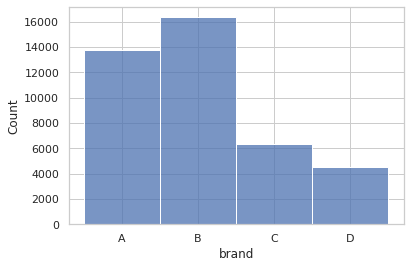

In [ ]:
sns.histplot(x=df['brand'])

#### `de_children`

In [ ]:
# Move this column to num_cols
cate_cols.remove('de_children')
num_cols.append('de_children')

### Datetime features

#### `de_date_joined`

In [ ]:
now = dt.now()

In [ ]:
# Convert to days joined
df['de_date_joined'] = (now - pd.to_datetime(df['de_date_joined'])).apply(get_days)

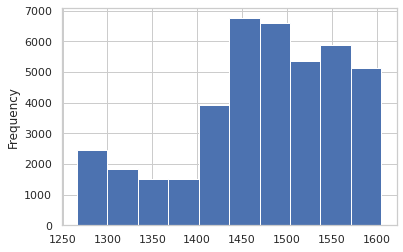

In [ ]:
df['de_date_joined'].plot.hist()

#### `fb_last_updated_date` need to be fixed

In [ ]:
now = dt.now(timezone.utc)
df['fb_last_updated_date'] = (now - pd.to_datetime(df['fb_last_updated_date'])).apply(get_days)

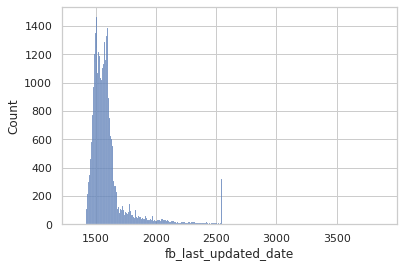

In [ ]:
sns.histplot(df['fb_last_updated_date'])

#### `fb_dob`

In [ ]:
len(df.columns)

27

In [ ]:
# Remove fb_dob as it has the same meaning of de_age
df['fb_dob'].isnull().sum()
df.drop(columns=['fb_dob'], axis=0, inplace=True)

### Continous features

In [ ]:
# Update columns in date to continous columns
for col in date_cols:
  num_cols.append(col)

num_cols = [x for x in num_cols if x in df.columns]

In [ ]:
df[num_cols].apply(pd.Series.nunique)

index                          41022
de_age                            50
de_num_friends                  4531
de_monthly_salary                 40
de_employment_duration            52
ph_total_contacts               1588
percent_incoming_nighttime      1983
percent_outgoing_daytime        5927
duration_incoming_daytime       8087
duration_outgoing_daytime       8080
percent_incoming_daytime        4286
percent_other_calls             5186
duration_outgoing_nighttime     5288
percent_outgoing_nighttime      3754
total_calls                      826
duration_incoming_nighttime     4643
ph_app_list                      269
de_children                        5
de_date_joined                   203
fb_last_updated_date            1206
dtype: int64

#### Outliers

In [ ]:
# Columns with minus values
minus_cols = df.describe().loc[['min']].to_dict().items()
tmp = []
for k, v in minus_cols:
  if v['min'] < 0:
    tmp.append(k)
minus_cols = tmp

In [ ]:
# Keep only values >= 0:
for col in minus_cols:
  df = df.loc[(df[col] >= 0) | (df[col].isnull()), :]

In [ ]:
len(df)

41015

View outliers base on Z-Score

In [ ]:
df2 = df.copy()

In [ ]:
# Let's try with threshold = 5
sum(outlier_view(df[num_cols], 5)['total_outliers'])

2289

In [ ]:
# Let's remove outliers out of threshold 4h
df = outlier_remove(df, num_cols, 5)
len(df)

38763

#### Missing columns

In [ ]:
# Missing columns
df[num_cols].isna().sum()

index                             0
de_age                            0
de_num_friends                    0
de_monthly_salary                 0
de_employment_duration            0
ph_total_contacts                 0
percent_incoming_nighttime     2031
percent_outgoing_daytime       2031
duration_incoming_daytime      2031
duration_outgoing_daytime      2031
percent_incoming_daytime       2031
percent_other_calls            2031
duration_outgoing_nighttime    2031
percent_outgoing_nighttime     2031
total_calls                    2031
duration_incoming_nighttime    2031
ph_app_list                       0
de_children                       0
de_date_joined                    0
fb_last_updated_date           1407
dtype: int64

In [ ]:
# Missing columns
missing_cols = []
for k, v in df.isnull().sum().to_dict().items():
  if v > 0:
    missing_cols.append(k)

In [ ]:
missing_cols

['fb_last_updated_date',
 'percent_incoming_nighttime',
 'percent_outgoing_daytime',
 'duration_incoming_daytime',
 'duration_outgoing_daytime',
 'percent_incoming_daytime',
 'percent_other_calls',
 'duration_outgoing_nighttime',
 'percent_outgoing_nighttime',
 'total_calls',
 'duration_incoming_nighttime']

In [ ]:
# Let's replace missing values by column mean value
for col in missing_cols:
  df[col] = df[col].fillna(df[col].mean())

In [ ]:
# Let's check null values again
df[missing_cols].isnull().sum()

fb_last_updated_date           0
percent_incoming_nighttime     0
percent_outgoing_daytime       0
duration_incoming_daytime      0
duration_outgoing_daytime      0
percent_incoming_daytime       0
percent_other_calls            0
duration_outgoing_nighttime    0
percent_outgoing_nighttime     0
total_calls                    0
duration_incoming_nighttime    0
dtype: int64

## Regularization

In [ ]:
# Reset index
df = df.reset_index().drop(columns=['level_0'])

### Discrete features

In [ ]:
# Update categorical columns
cate_cols = [col for col in cate_cols if col in df.columns]

In [ ]:
# Remove flag_bad as it is our output
cate_cols.remove('flag_bad')

In [ ]:
df2 = df.copy()

Let's use one-hot encoding for these type of values

In [ ]:
# Create a One Hot Coder
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
cate_cols

['brand',
 'de_gender',
 'de_employment_type',
 'de_education',
 'de_marital_status']

In [ ]:
# Encode the data in categorical values
df_cate_encoded = enc.fit_transform(df[cate_cols])
df_cate_encoded = pd.DataFrame.sparse.from_spmatrix(df_cate_encoded)

### Continous features

Here we use Min-max scaler to standardize our data

In [ ]:
# Create a Scaler
scaler = MinMaxScaler()

In [ ]:
# Scale the data
df_num_scaled = scaler.fit_transform(df[num_cols])
df_num_scaled = pd.DataFrame(df_num_scaled, columns=num_cols)

# IV. Modeling

In [ ]:
df2 = df.copy()

## Train-test split

In [ ]:
# Final dataset ready to be trained
X = pd.concat([df_cate_encoded, df_num_scaled], axis = 1)
y = df['flag_bad']

In [ ]:
# Split to train & test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# Split to train & validation:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Train the model

### CNN

In [ ]:
def create_cnn(units, input_dim):

  # Create a sequential
  model = Sequential()

  # Add the first hidden layer
  model.add(Dense(int(units), activation='relu', input_dim=input_dim))

  # Add the 2nd hidden layer
  unit_2 = units // 2
  model.add(Dense(unit_2, activation='relu'))

  # Add the 3rd hidden layer
  unit_3 = unit_2 // 2
  model.add(Dense(unit_3, activation='relu'))

  # Add the output layer
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# create model
input_dim = len(X_train.columns)

units = 128
cnn = create_cnn(units, input_dim)
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               5120      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,489
Trainable params: 15,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training
cnn.fit(X_train, y_train, epochs = 50)

Epoch 1/50
776/776 [==============================] - 2s 2ms/step - loss: 0.3789 - accuracy: 0.8710
Epoch 2/50
776/776 [==============================] - 2s 2ms/step - loss: 0.3672 - accuracy: 0.8718
Epoch 3/50
776/776 [==============================] - 2s 2ms/step - loss: 0.3634 - accuracy: 0.8718
Epoch 4/50
776/776 [==============================] - 2s 2ms/step - loss: 0.3614 - accuracy: 0.8718
Epoch 5/50
776/776 [==============================] - 2s 2ms/step - loss: 0.3580 - accuracy: 0.8719
Epoch 6/50
776/776 [==============================] - 2s 2ms/step - loss: 0.3561 - accuracy: 0.8718
Epoch 7/50
776/776 [==============================] - 3s 4ms/step - loss: 0.3540 - accuracy: 0.8724
Epoch 8/50
776/776 [==============================] - 3s 4ms/step - loss: 0.3522 - accuracy: 0.8721
Epoch 9/50
776/776 [==============================] - 3s 3ms/step - loss: 0.3495 - accuracy: 0.8726
Epoch 10/50
776/776 [==============================] - 2s 3ms/step - loss: 0.3471 - accuracy: 0.8732

In [ ]:
# Accuracy
scores = cnn.evaluate(X_train, y_train)
print(f'Training accuracy: {round(scores[1]*100,2)}')

scores = cnn.evaluate(X_test, y_test)
print(f'Testing accuracy: {round(scores[1]*100,2)}')

776/776 [==============================] - 1s 1ms/step - loss: 0.1978 - accuracy: 0.9259
Training accuracy: 92.59
243/243 [==============================] - 1s 3ms/step - loss: 0.6829 - accuracy: 0.8301
Testing accuracy: 83.01


### Linear regresion

In [ ]:
# Create linear regression object
regr = LinearRegression()

In [ ]:
# Train the model using the training sets
regr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


LinearRegression()

In [ ]:
# Predict on Test set
y_pred = regr.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [ ]:
# Convert from numpy array to series
def conver_to_result(value):
  if value < 0.5:
    return 0
  else:
    return 1
    
y_pred = pd.Series(y_pred).apply(conver_to_result)

In [ ]:
# Evaluation on Test set
print(f'R-squared = {r2_score(y_test, y_pred):.4f}')
print(f'RMSE       = {mean_squared_error(y_test, y_pred)**0.5:.2f}')
print(f'Accuracy = {round(accuracy_score(y_test, y_pred), 2)}')

R-squared = -0.1505
RMSE       = 0.36
Accuracy = 0.87


## Features selection

### Heatmap

Let's plot a heatmap to get a deeper understanding of feature correlation

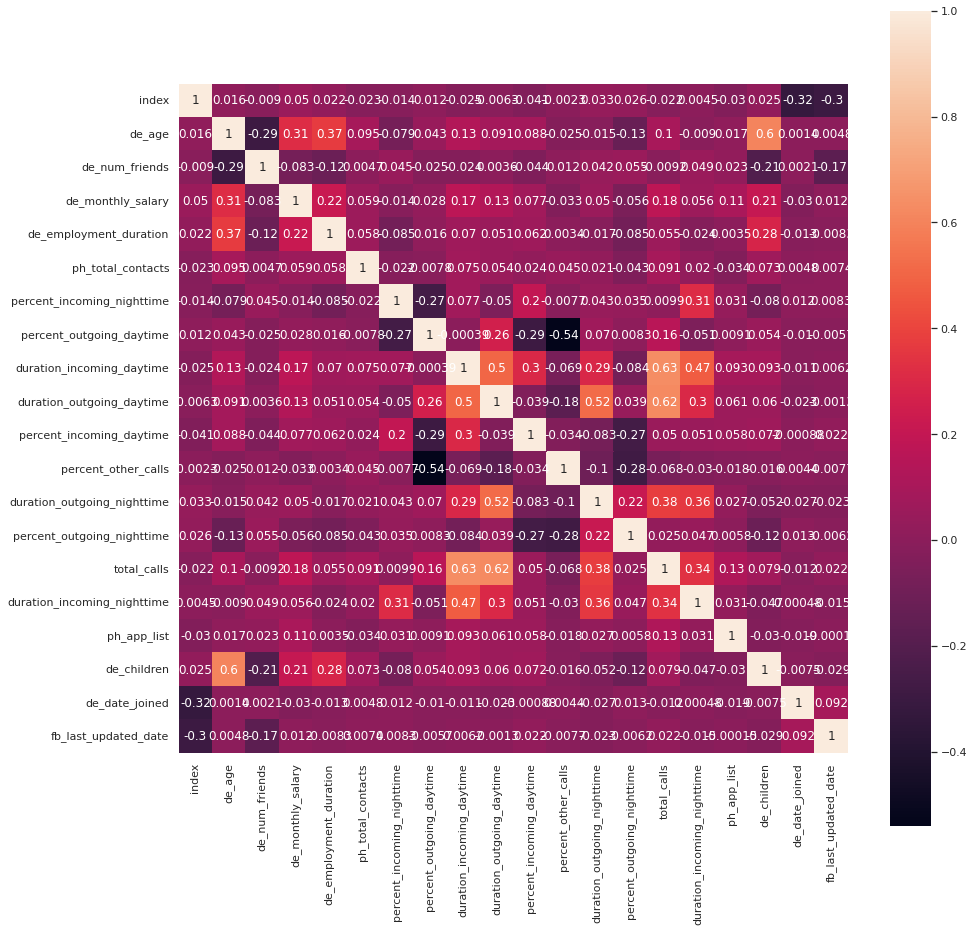

In [ ]:
corr_matrix = df[num_cols]._get_numeric_data().sample(frac=0.25).corr()

# Plot the heatmap of Correlation
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True);
plt.show()

Some features have higher correlation than others: `de_age`, `de_martial_status` and `de_children`. However, it's better to keep these features since the correlation is only around 0.6.

### Feature importance with Random Forrest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# fit an Extra Trees model to the data
rdf = RandomForestRegressor()
rdf.fit(df[num_cols], df['flag_bad'])
feature_importances = pd.DataFrame(rdf.feature_importances_,
                                   index = num_cols,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)
ft = list(feature_importances[:25].index)
print(ft)

                             importance
de_num_friends                 0.081867
index                          0.072353
fb_last_updated_date           0.069501
total_calls                    0.062741
ph_app_list                    0.061678
de_date_joined                 0.061239
percent_other_calls            0.056547
percent_incoming_daytime       0.054121
percent_outgoing_daytime       0.050763
de_age                         0.050625
duration_incoming_daytime      0.049522
duration_outgoing_daytime      0.049177
percent_outgoing_nighttime     0.047379
de_employment_duration         0.046435
percent_incoming_nighttime     0.038051
duration_incoming_nighttime    0.036161
duration_outgoing_nighttime    0.034272
ph_total_contacts              0.031463
de_monthly_salary              0.028859
de_children                    0.017246
['de_num_friends', 'index', 'fb_last_updated_date', 'total_calls', 'ph_app_list', 'de_date_joined', 'percent_other_calls', 'percent_incoming_daytime', 'percent_

In [ ]:
cate_cols

['brand',
 'de_gender',
 'de_employment_type',
 'de_education',
 'de_marital_status']